# Bagging and the Random Forest Algorithm

Before starting, let's import a few packages.

In [1]:
import numpy as np
from numpy.matlib import repmat
import matplotlib.pyplot as plt
from scipy.io import loadmat

In addition, we'll create a 2D spiral dataset of size 150 for visualization and a high dimensional dataset <a href="https://archive.ics.uci.edu/ml/datasets/Ionosphere">ION</a>, which we will use as our binary test classification problem.

In [2]:
def spiraldata(N=300):
    r = np.linspace(1, 2 * np.pi, N)
    X_train1 = np.array([np.sin(2 * r) * r, np.cos(2 * r) * r]).T
    X_train2 = np.array([np.sin(2 * r + np.pi) * r, np.cos(2 * r + np.pi) * r]).T
    X_train = np.concatenate([X_train1, X_train2], axis=0)
    y_train = np.concatenate([np.ones(N), -1 * np.ones(N)])
    X_train = X_train + np.random.randn(X_train.shape[0], X_train.shape[1]) * 0.2
    
    X_test = X_train[::2,:]
    y_test = y_train[::2]
    X_train = X_train[1::2,:]
    y_train = y_train[1::2]
    
    return X_train, y_train, X_test, y_test

In [3]:
def iondata():
    data = loadmat('../data/ion.mat')
    xTrIon = data['xTr'].T
    yTrIon = data['yTr'].flatten()
    xTeIon = data['xTe'].T
    yTeIon = data['yTe'].flatten()
    
    return xTrIon, yTrIon, xTeIon, yTeIon

In [4]:
xTrSpiral, yTrSpiral, xTeSpiral, yTeSpiral = spiraldata(150)
xTrIon, yTrIon, xTeIon, yTeIon = iondata()

You will use the regression tree from a previous project. As a reminder, the following code shows you how to instantiate a decision tree:

In [5]:
class TreeNode(object):
    
    def __init__(self, left, right, parent, cutoff_id, cutoff_val, prediction):
        self.left = left
        self.right = right
        self.parent = parent
        self.cutoff_id = cutoff_id
        self.cutoff_val = cutoff_val
        self.prediction = prediction

In [6]:
class RegressionTree:
    
    def __init__(self, depth=np.inf, weights=None):
        self.depth = depth
        self.weights = weights
        self.root = None
        
    def fit(self, X_train, y_train):
        self.root = self.cart(X_train, y_train, self.depth, self.weights)
        
    def predict(self, X_train):
        if self.root is None:
            raise NotImplementedError('The tree is not fitted yet!')
            
        return self.evaltree(self.root, X_train)
    
    def sqsplit(self, X_train, y_train, weights=None):
        """
        This method finds the best feature, cut value, and loss value.
        
        Inputs:
        ------
        X_train : n x d matrix of data points
        y_train : n-dimensional vector of labels
        weights : n-dimensional weight vector for data points
        
        Outputs:
        -------
        feature  : index of the best cut's feature
        cut      : cut-value of the best cut
        bestloss : loss of the best cut
        """
        N, D = X_train.shape
        assert D > 0 # must have at least one dimension
        assert N > 1 # must have at least two samples
        if weights is None: # if no weights are passed on, assign uniform weights
            weights = np.ones(N)
            
        weights = weights / sum(weights) # normalize weights
        bestloss = np.inf
        feature = np.inf
        cut = np.inf
        
        # Begin Solution
        for d in range(D):
            ii = X_train[:,d].argsort() # sort data along dimensions
            xs = X_train[ii,d]          # sorted feature values
            ws = weights[ii]            # sorted weights
            ys = y_train[ii]            # sorted labels
            
            # Initialize constants
            sL  = 0.0             # mean squared label on left side
            muL = 0.0             # mean label on left side
            wL  = 0.0             # total weight on left side
            sR  = ws.dot(ys ** 2) # mean squared label on right 
            muR = ws.dot(ys)      # mean label on right
            wR  = sum(ws)         # weight on right
            
            pj = 0 # index counter
            idif = np.where(np.abs(np.diff(xs, axis=0)) > np.finfo(float).eps * 100)[0]
            for j in idif:
                deltas  = np.dot(ys[pj:j+1] ** 2, ws[pj:j+1])
                deltamu = np.dot(ws[pj:j+1], ys[pj:j+1])
                deltaw  = np.sum(ws[pj:j+1])
                
                sL  += deltas
                muL += deltamu
                wL  += deltaw
                
                sR  -= deltas
                muR -= deltamu
                wR  -= deltaw
                
                L = sL - muL ** 2 / wL
                R = sR - muR ** 2 / wR
                loss = L + R
                
                if loss < bestloss:
                    feature = d
                    cut = (xs[j] + xs[j+1]) / 2
                    bestloss = loss
                pj = j + 1
                
        assert feature != np.inf and cut != np.inf
        
        return feature, cut, bestloss
    
    def cart(self, X_train, y_train, depth=np.inf, weights=None):
        """
        This method builds a CART tree.
        
        The maximum tree depth is defined by "maxdepth" (maxdepth=2 means one split).
        Each example can be weighted with "weights".
        
        Inputs:
        ------
        X_train  : n x d matrix of data
        y_train  : n-dimensional vector
        maxdepth : maximum tree depth
        weights  : n-dimensional weight vector for data points
        
        Outputs:
        -------
        tree : root of decision tree
        """
        n, d = X_train.shape
        if weights is None:
            w = np.ones(n) / float(n)
        else:
            w = weights
        
        # Begin Solution
        index = np.arange(n)
        prediction = y_train.dot(w) / float(np.sum(w))
        if depth == 0 or np.all(y_train == y_train[0]) or np.max(np.abs(np.diff(X_train, axis=0))) < (np.finfo(float).eps * 100):
            # Create leaf Node
            return TreeNode(None, None, None, None, None, prediction)
        else:
            feature, cut, h = self.sqsplit(X_train, y_train, w)
            left_idx = index[X_train[:,feature] <= cut]
            right_idx = index[X_train[:,feature] > cut]
            left_w = w[left_idx]
            right_w = w[right_idx]
            left = self.cart(X_train[left_idx,:], y_train[left_idx], depth=depth-1, weights=left_w)
            right = self.cart(X_train[right_idx,:], y_train[right_idx], depth=depth-1, weights=right_w)
            currNode = TreeNode(left, right, None, feature, cut, prediction)
            left.parent  = currNode
            right.parent = currNode
            
            return currNode
        
    def evaltree(self, root, X_test, idx=[]):
        """
        This method evaluates test data using the decision tree root.
        
        Inputs:
        ------
        root   : TreeNode decision tree
        X_test : n x d matrix of data points
        
        Outputs:
        -------
        pred: n-dimensional vector of predictions
        """
        assert root is not None
        n = X_test.shape[0]
        pred = np.zeros(n)
        
        if len(idx) == 0:
            idx = np.ones(n) == 1
            
        if root.left is None and root.right is None:
            return np.ones(sum(idx)) * root.prediction
        
        assert root.left is not None and root.right is not None
        feature, cutoff = root.cutoff_id, root.cutoff_val
        
        idxL = idx & (X_test[:,feature] <= cutoff)
        if root.left.left == None and root.left.right == None:
            pred[idxL] = root.left.prediction
        else:
            pred[idxL] = self.evaltree(root.left, X_test, idxL)
            
        idxR = idx & (X_test[:,feature] > cutoff)
        if root.right.left == None and root.right.right == None:
            pred[idxR] = root.right.prediction
        else:
            pred[idxR] = self.evaltree(root.right, X_test, idxR)
            
        return pred[idx]

In [7]:
# Create a regression tree with no restriction on its depth
# and weights for each training example to be 1
# if you want to create a tree of max_depth k
# then call RegressionTree(depth=k)
tree = RegressionTree(depth=np.inf)

# To fit/train the regression tree
tree.fit(xTrSpiral, yTrSpiral)

# To use the trained regression tree to predict a score for the example
score = tree.predict(xTrSpiral)

# To use the trained regression tree to make a +1/-1 prediction
pred = np.sign(tree.predict(xTrSpiral))

tr_err = np.mean((np.sign(tree.predict(xTrSpiral)) - yTrSpiral) ** 2)
te_err = np.mean((np.sign(tree.predict(xTeSpiral)) - yTeSpiral) ** 2)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

Training error: 0.0000
Testing error:  0.0733


<p>The following code defines a function <code>visclassifier()</code>, which plots the decision boundary of a classifier in 2 dimensions. Execute the following code to see what the decision boundary of your tree looks like on the spiral data set.</p>

In [8]:
def visclassifier(fun, X_train, y_train):
    y_train = np.array(y_train).flatten()
    symbols = ['ko', 'kx']
    marker_symbols = ['o', 'x']
    mycolors = [[0.5, 0.5, 1], [1, 0.5, 0.5]]
    
    # get the unique values from labels array
    classvals = np.unique(y_train)
    
    plt.figure()
    
    # return 300 evenly spaced numbers over this interval
    res = 300
    xrange = np.linspace(min(X_train[:, 0]), max(X_train[:, 0]), res)
    yrange = np.linspace(min(X_train[:, 1]), max(X_train[:, 1]), res)
    
    # repeat this matrix 300 times for both axes
    pixelX = repmat(xrange, res, 1)
    pixelY = repmat(yrange, res, 1).T
    
    X_test = np.array([pixelX.flatten(), pixelY.flatten()]).T
    
    # test all of these points on the grid
    testpreds = fun(X_test)
    
    # reshape it back together to make our grid
    Z = testpreds.reshape(res, res)
    # Z[0,0] = 1 # optional: scale the colors correctly
    
    # fill in the contours for these predictions
    plt.contourf(pixelX, pixelY, np.sign(Z), colors=mycolors)
    
    # creates x's and o's for training set
    for idx, c in enumerate(classvals):
        plt.scatter(X_train[y_train == c,0], X_train[y_train == c,1], marker=marker_symbols[idx], color='k')
        
    plt.axis('tight')
    plt.show()

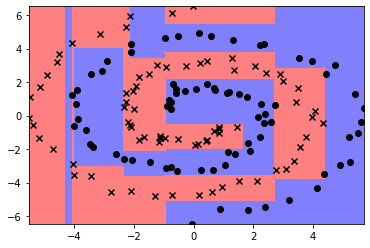

Training error: 0.0000
Testing error:  0.0733


In [9]:
tree = RegressionTree(depth=np.inf)
tree.fit(xTrSpiral, yTrSpiral) # compute tree on training data
visclassifier(lambda X: tree.predict(X), xTrSpiral, yTrSpiral)

print("Training error: %.4f" % np.mean(np.sign(tree.predict(xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(tree.predict(xTeSpiral)) != yTeSpiral))

<h2>Bagging in Action</h2>

<h3>Part One: Implement <code>forest</code></h3>

<p>CART trees are known to be high variance classifiers (if trained to full depth). An effective way to prevent overfitting is to use <b>Bagging</b> (short for <strong>b</strong>ootstrap <strong>ag</strong>gregating).

Implement the function <code>forest</code>, which builds a forest of regression trees. Each tree should be built using training data drawn by randomly sampling $n$ examples from the training data with replacement. <em>Do not</em> randomly sample features. The function outputs a list of trees.</p>

In [10]:
def forest(X_train, y_train, m, maxdepth=np.inf):
    """
    This function creates a random forest.
    
    Inputs:
    ------
    X_train  : n x d matrix of data points
    y_train  : n-dimensional vector of labels
    m        : number of trees in the forest
    maxdepth : maximum depth of tree
    
    Outputs:
    -------
    trees : list of decision trees of length m
    """
    n, d = X_train.shape
    trees = []
    
    for _ in range(m):
        ix = np.random.choice(list(range(n)), n)
        xt, yt = X_train[ix,:], y_train[ix]
        tree = RegressionTree(depth=maxdepth)
        tree.fit(xt, yt)
        trees.append(tree)
    
    return trees

<h3>Part Two: Implement <code>evalforest</code></h3>

<p>Now implement the function <code>evalforest</code>, which should take as input a set of $m$ trees and a set of $n$ test inputs and return the average prediction of all the trees.</p>

<p>Note that for bagging, we take the average over all trees weighted equally.</p>

In [11]:
def evalforest(trees, X):
    """
    This function evaluates X using trees.
    
    Inputs:
    ------
    trees : list of TreeNode decision trees of length m
    X     : n x d matrix of data points
    
    Outputs:
    -------
    pred: n-dimensional vector of predictions
    """
    m = len(trees)
    n,d = X.shape
    pred = np.zeros(n)
    
    for tree in trees:
        pred += tree.predict(X)
    
    pred /= m
    
    return pred

<h3>Visualize the Decision Boundary</h3>

<p>The following script visualizes the decision boundary of an ensemble of decision trees.</p>

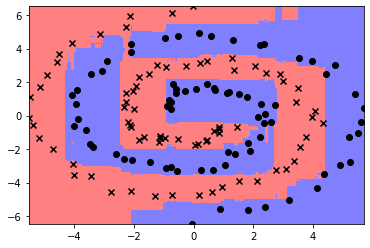

Training error: 0.0000
Testing error:  0.0600


In [12]:
trees = forest(xTrSpiral, yTrSpiral, 50) # compute tree on training data
visclassifier(lambda X: evalforest(trees, X), xTrSpiral, yTrSpiral)

print("Training error: %.4f" % np.mean(np.sign(evalforest(trees, xTrSpiral)) != yTrSpiral))
print("Testing error:  %.4f" % np.mean(np.sign(evalforest(trees, xTeSpiral)) != yTeSpiral))

<h3>Evaluate Test and Training Error</h3>

<p>The following script evaluates the test and training error of an ensemble of decision trees as we vary the number of trees.</p>

[0]training err = 0.0605	testing err = 0.1857
[1]training err = 0.0641	testing err = 0.2143
[2]training err = 0.0249	testing err = 0.1714
[3]training err = 0.0320	testing err = 0.1571
[4]training err = 0.0071	testing err = 0.1000
[5]training err = 0.0107	testing err = 0.0857
[6]training err = 0.0000	testing err = 0.0714
[7]training err = 0.0071	testing err = 0.0857
[8]training err = 0.0000	testing err = 0.0857
[9]training err = 0.0071	testing err = 0.0714
[10]training err = 0.0000	testing err = 0.0714
[11]training err = 0.0000	testing err = 0.1000
[12]training err = 0.0000	testing err = 0.0857
[13]training err = 0.0036	testing err = 0.1000
[14]training err = 0.0000	testing err = 0.0857
[15]training err = 0.0000	testing err = 0.0857
[16]training err = 0.0000	testing err = 0.0571
[17]training err = 0.0000	testing err = 0.0714
[18]training err = 0.0000	testing err = 0.0714
[19]training err = 0.0000	testing err = 0.0714


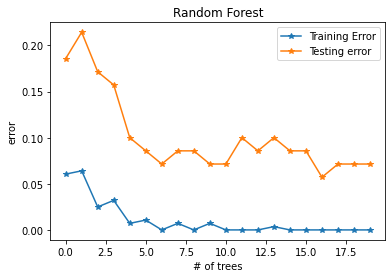

In [13]:
M = 20 # max number of trees
err_trB = [] # training error
err_teB = [] # testing error

alltrees = forest(xTrIon, yTrIon, M)
for i in range(M):
    trees = alltrees[:i+1]
    trErr = np.mean(np.sign(evalforest(trees, xTrIon)) != yTrIon)
    teErr = np.mean(np.sign(evalforest(trees, xTeIon)) != yTeIon)
    err_trB.append(trErr)
    err_teB.append(teErr)
    print("[%d]training err = %.4f\ttesting err = %.4f" % (i, trErr, teErr))

plt.figure()
line_tr, = plt.plot(range(M), err_trB, '-*', label="Training Error")
line_te, = plt.plot(range(M), err_teB, '-*', label="Testing error")
plt.title("Random Forest")
plt.legend(handles=[line_tr, line_te])
plt.xlabel("# of trees")
plt.ylabel("error")
plt.show()